In [1]:
#accessing netcdf files from Hector's folders
import os, glob, sys
sys.path.append("//nobackup//amondal//Python//Hector_Python_Scripts")
sys.path.append("//nobackup/amondal//Python//mit_geos_analysis")
#from mds_store import openmdsdataset
#playing with netcdf - xarray
import numpy as np
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt
# How about visualization?
%matplotlib inline
import netCDF4
from netCDF4 import Dataset
#from xmitgcm import open_mdsdataset
from GetNCDataSet import getMITNCDataSet
from MITllc2160Depth import *
sys.path.append("//nobackup/amondal//Python//xmitgcm//xmitgcm")
from xmitgcm.mds_store import open_mdsdataset
import xrft


from dask.distributed import Client
client = Client(memory_limit='100GB',n_workers = 40, threads_per_worker=1)

In [2]:
import xgcm

In [2]:
from spectral_analysis_code import *

In [4]:
#depthToZlayer(25)
zlayerToDepth(25)

154.99

Let me look at hbl for my region:

In [14]:
kpphbl = getMITNCDataSet('/nobackup/amondal/NCData/20211228_HBL_GulfStream_FULLYEAR/', 'KPPhbl', 0,0 )

Time combined dataset has been opened.
I concatenated the first Z-layer


In [15]:
hbl = kpphbl.KPPhbl.compute()

In [1]:
%matplotlib inline
hbl[1300].plot()

NameError: name 'hbl' is not defined

In [16]:
hbl_spring = hbl[0:2050,100:-100, 100:-100]

In [17]:
hbl_spring_winmean = movingWindowAverage(hbl_spring, 'time', 24, 'lat')

In [18]:
hblc_spring_winmean = hbl_spring_winmean.compute()

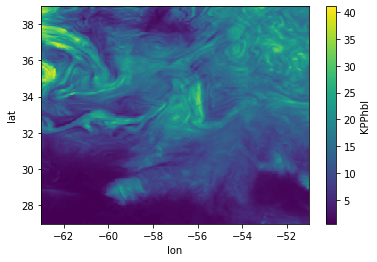

In [22]:
%matplotlib inline
hblc_spring_winmean[1600].plot()

In [5]:
def coarseGrainHbl_MAX(hblset):
    periodlength = 24
    periodnum = int(hblset.dims['time'] / periodlength)
    hblsel = hblset['KPPhbl']
    perioddepths = np.empty(periodnum)
    hblcoarsegrain = np.empty(0)
    for index in range(0,periodnum):
        perioddepths[index] = hblsel[index*periodlength:(index+1)*periodlength].max(dim='time').values
        hblcoarsegrain = np.concatenate((hblcoarsegrain, np.full(periodlength, perioddepths[index])),casting='same_kind')
    hMax = xr.DataArray(data = hblcoarsegrain, dims = hblsel.dims, coords = hblsel.coords)
    return hMax

def coarseGrainHblArray_MAX(hblarray, cgperiod):
    periodlength = cgperiod #hours over which you want to coarse grain
    periodnum = int(hblarray['time'].size / periodlength)
    hblsel = hblarray
    perioddepths = np.empty(periodnum)
    hblcoarsegrain = np.empty(0)
    for index in range(0,periodnum):
        perioddepths[index] = hblsel[index*periodlength:(index+1)*periodlength].max(dim='time').values
        hblcoarsegrain = np.concatenate((hblcoarsegrain, np.full(periodlength, perioddepths[index])),casting='same_kind')
    hMax = xr.DataArray(data = hblcoarsegrain, dims = hblsel.dims, coords = hblsel.coords)
    return hMax

Text(0.5, 1.0, 'Max Gulf Stream HBL (Coarse Grained by Max over 3 days)')

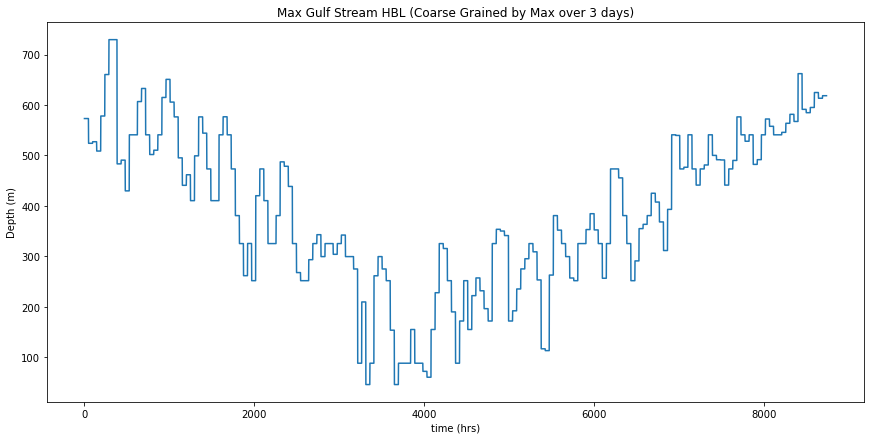

In [6]:
hblm = hbl.max(["lat","lon"])
hblm_cg = coarseGrainHblArray_MAX(hblm, 48)
%matplotlib inline
hblm_cg.plot(aspect=2, size=6)
plt.tight_layout()
plt.xlabel('time (hrs)')
plt.ylabel('Depth (m)')
plt.title('Max Gulf Stream HBL (Coarse Grained by Max over 3 days)')

Text(0.5, 1.0, 'Max Gulf Stream HBL (Coarse Grained by Max over 3 days)')

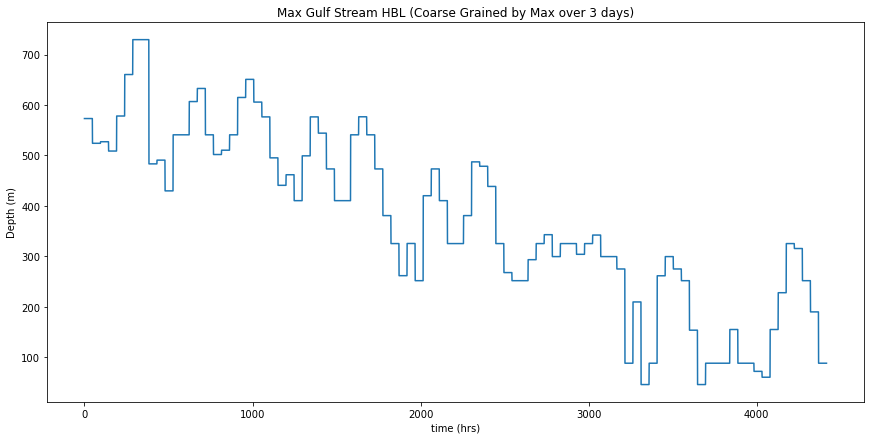

In [7]:
hblm = hbl.max(["lat","lon"])
hblm_cg = coarseGrainHblArray_MAX(hblm, 48)
%matplotlib inline
hblm_cg[0:4416].plot(aspect=2, size=6)
plt.tight_layout()
plt.xlabel('time (hrs)')
plt.ylabel('Depth (m)')
plt.title('Max Gulf Stream HBL (Coarse Grained by Max over 3 days)')

So Patrice suggested making movies of W T in the bigger region in real space/time domain. He also suggested doing a moving window of length 3 days. This is for 6 months of gulf stream data.

In [4]:
T15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/', 'Theta', 15,15 )
T15c = T15.compute()

Time combined dataset has been opened.
I concatenated the first Z-layer


Cool, so this is the the right folder! So I can do Zlayers 25,30,35, and maybe 40? We could even do 45.

In [5]:
W15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/', 'W', 15,15)
W15c = W15.compute()

Time combined dataset has been opened.
I concatenated the first Z-layer


2/2/20 - I'm going to use the smaller dataset that I have. The one that I gave Hector. I imagine this will help performance.

In [5]:
T15 = xr.open_dataset('/nobackup/amondal/NCData/Theta15_reg_for_Hector.nc4')
W15 = xr.open_dataset('/nobackup/amondal/NCData/W15_reg_for_Hector.nc4')

In [6]:
Theta15_reg = T15.__xarray_dataarray_variable__
W15_reg = W15.__xarray_dataarray_variable__
# if you use the full domain use what's below
#Theta15_reg = regularizeCoordinates(T15.Theta,'linear',timeunits = 'hours')
#W15_reg = regularizeCoordinates(W15.W, 'linear', timeunits = 'hours')

In [7]:
Theta15_reg_t = xrft.detrend(Theta15_reg, dim = ['time'], detrend_type = 'linear')
W15_reg_t = xrft.detrend(W15_reg, dim = ['time'], detrend_type = 'linear')
Theta15_reg_txy = xrft.detrend(Theta15_reg_t, dim = ['xdim','ydim'], detrend_type = 'linear')
W15_reg_txy = xrft.detrend(W15_reg_t, dim = ['xdim', 'ydim'], detrend_type = 'linear')

In [9]:
Wp_lp = movingWindowAverage(W15_reg_txy[0:720], 'time', 24, 'xdim').compute() #lp stands for "low pass"
Tp_lp = movingWindowAverage(Theta15_reg_txy[0:720], 'time', 24, 'xdim').compute()

In [10]:
Wp_lp

<xarray.DataArray '__xarray_dataarray_variable__' (time: 2184, xdim: 300, ydim: 375)>
array([[[-9.31246413e-05, -9.31373259e-05,  8.34582297e-06, ...,
          2.75870059e-04, -5.97220946e-05,  2.05251853e-04],
        [-1.96281789e-04, -1.96294474e-04, -2.88408964e-06, ...,
          1.12396124e-04, -1.88355357e-04,  1.66572348e-04],
        [-1.51114911e-04, -1.51127596e-04, -4.75813747e-05, ...,
          1.73569898e-04, -1.41440164e-04,  2.21760369e-04],
        ...,
        [ 8.49287071e-06,  8.48018619e-06,  2.12719779e-05, ...,
          2.46867941e-04, -1.75370860e-05, -1.88536237e-04],
        [ 1.48515823e-04,  1.48503139e-04,  9.12048916e-05, ...,
         -3.92234388e-05, -5.67663754e-05, -9.43503715e-05],
        [ 4.68742993e-05,  4.68616148e-05, -7.62565630e-05, ...,
          1.58660490e-04,  7.72416406e-05,  1.45047590e-04]],

       [[-9.23421990e-05, -9.23577499e-05,  8.66675844e-06, ...,
          2.86238998e-04, -6.64188158e-05,  1.92745476e-04],
        [-2.01621108e-04, -2.01636659e-04, -2.96258526e-06, ...,
          1.22028531e-04, -1.73433035e-04,  1.61911461e-04],
        [-1.56648573e-04, -1.56664123e-04, -5.32578294e-05, ...,
          1.71787626e-04, -1.28271767e-04,  2.14768008e-04],
...
        [ 4.53375472e-05,  4.53390571e-05,  8.36864785e-06, ...,
         -1.53456516e-04, -7.87079292e-05, -2.28889096e-05],
        [ 8.22700773e-06,  8.22851764e-06,  2.72369885e-06, ...,
         -1.40007969e-04, -1.18069556e-04, -1.14914134e-04],
        [-1.06280642e-05, -1.06265543e-05, -9.84090444e-06, ...,
         -8.48677596e-05, -3.55495965e-05, -2.75818527e-05]],

       [[ 8.37344991e-05,  8.37345823e-05,  3.86633411e-05, ...,
         -6.66653072e-05, -3.83852419e-05,  5.48030973e-05],
        [ 1.53302658e-04,  1.53302741e-04,  1.01776738e-04, ...,
         -9.11727987e-05, -4.69272963e-05,  6.97529563e-06],
        [ 1.87812075e-04,  1.87812158e-04,  1.58394868e-04, ...,
         -6.52275547e-05, -5.37212364e-05, -3.84135347e-05],
        ...,
        [ 8.76115504e-05,  8.76116336e-05,  6.88676473e-07, ...,
         -1.67102885e-04, -7.55398814e-05, -3.54356757e-06],
        [ 4.96704481e-05,  4.96705313e-05, -1.03227179e-05, ...,
         -1.40861072e-04, -1.15385981e-04, -9.93529862e-05],
        [ 1.03175489e-05,  1.03176320e-05, -3.36285974e-05, ...,
         -6.37117306e-05, -1.59803192e-05, -1.18549788e-05]]])
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 ... 2.181e+03 2.182e+03 2.183e+03
  * xdim     (xdim) float64 0.0 2.224 4.448 6.672 ... 658.3 660.5 662.7 665.0
  * ydim     (ydim) float64 0.0 4.448 8.896 ... 1.655e+03 1.659e+03 1.664e+03

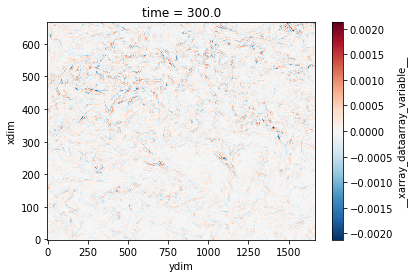

In [13]:
%matplotlib inline
Tp_lp[300].plot()

In [10]:
WpTp = Wp_lp * Tp_lp*4.2e6 # rho Cp

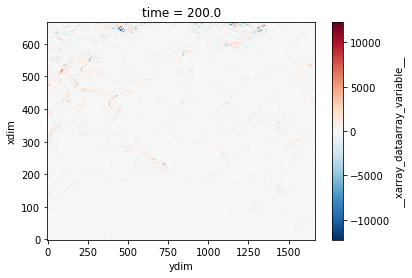

In [11]:
%matplotlib inline
WpTp[200].plot()
#so a few things, looking at these snap shots, you can absolutely get rid of the top levels of your colorbar.

So 1) you need to figure out how to plot these much nicer. Maybe in xarray (spend at most an hour to figure that out).
2) Let's take a few snapshots at other length scales
3) Maybe get these in degrees. It will probably be more sensible to get these in degrees than kilometers?
4) We can try to do snapshots of both 

In [11]:
def movingWindowAverage(xarraydata, dim, windowsize):
    chunks = xarraydata.chunk({"xdim": 100, "ydim": 100})
    chunks = xarraydata
    xavg = chunks / windowsize
    for index in range(1,windowsize):
        if (dim =='time'):
            xavg += chunks.shift(time=-1*index, fill_value = 0) / windowsize
            # add other potential dimensions. xarray.shift doesn't allow us to pick dimensions in an easier way
        else:
            xavg += xavg 
        
    return xavg[0:-1*windowsize] #this line only correctly works if the dim=='time'

#NOTE THE ROLLING METHOD IN XARRAY WOULD DO THIS AS WELL AND PROBABLY IN LESS LINES

In [20]:
WpTp_1month = WpTp[0:24*30]

In [21]:
WpTp_1month_movingavg = movingWindowAverage(WpTp_1month, 'time', 24)

In [22]:
WpTp_1month_movingavgc = WpTp_1month_movingavg.compute()

In [23]:
WpTp_1month_movingavgc

<xarray.DataArray (time: 696, xdim: 500, ydim: 500)>
array([[[ 2.84181469e-05,  1.13799231e-05, -2.47066745e-05, ...,
         -1.01601289e-05, -1.37507307e-05, -1.07677123e-05],
        [ 1.39654190e-06, -4.79153148e-05,  1.27752516e-05, ...,
         -2.54057968e-05, -4.09135578e-05, -8.75166161e-06],
        [-1.83265696e-05, -2.30708795e-06,  3.99065585e-05, ...,
         -5.80186553e-05, -1.33998539e-05,  3.74791312e-05],
        ...,
        [ 7.70691455e-06, -4.45365975e-05,  4.59590305e-06, ...,
         -1.05043631e-04, -4.38274739e-04, -6.78628302e-04],
        [ 3.05732299e-05, -1.53358158e-05,  4.45074599e-05, ...,
         -1.58235912e-04, -2.39228576e-04, -4.42993103e-04],
        [ 1.94208307e-04,  4.43701827e-05,  1.68789008e-05, ...,
         -3.11115089e-05, -2.90606928e-04, -4.38101252e-04]],

       [[ 1.73336196e-05,  7.24690099e-06, -2.16410037e-05, ...,
         -1.55518064e-05, -1.76255752e-05, -1.01748796e-05],
        [ 4.50281987e-06, -4.84769086e-05,  4.74422141e-06, ...,
         -2.97363556e-05, -4.38199665e-05, -1.28462553e-05],
        [-1.85048814e-05, -1.40555220e-05,  3.50929522e-05, ...,
         -5.79825628e-05, -1.82302462e-05,  3.90515064e-05],
...
        [-7.45870355e-05,  4.84420141e-06,  1.31989035e-04, ...,
          4.25870831e-08, -5.23559689e-06,  9.32822993e-07],
        [-1.87058926e-06,  8.12460658e-05,  1.10152020e-04, ...,
         -1.45016533e-05,  1.70628418e-06, -1.85979719e-06],
        [ 3.32720121e-05, -2.20913208e-06,  1.07130299e-05, ...,
          1.41039840e-06,  1.98999136e-06, -1.15196600e-06]],

       [[-6.35970084e-06, -3.30139269e-05, -3.76709145e-05, ...,
         -5.50498715e-06, -1.69444518e-06, -2.72120362e-06],
        [ 2.47431296e-05,  2.58468665e-05, -4.99172233e-05, ...,
         -4.17958990e-06,  3.22541938e-06, -4.94235062e-06],
        [ 6.79068101e-06,  5.25742947e-05, -1.58953883e-05, ...,
         -4.46053516e-06,  5.40895062e-07, -1.85491133e-06],
        ...,
        [-6.39983019e-05,  1.69335935e-05,  1.24274951e-04, ...,
         -1.59860342e-06, -5.21256498e-06,  8.41649015e-07],
        [ 2.69225398e-05,  8.46189995e-05,  8.62248705e-05, ...,
         -1.47175312e-05,  1.03084260e-06, -1.36718347e-06],
        [ 5.40663577e-05, -9.21080270e-06, -5.14740503e-06, ...,
          1.77727060e-06,  1.43066104e-06,  9.03069935e-08]]])
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 4.0 ... 692.0 693.0 694.0 695.0
  * xdim     (xdim) float64 0.0 1.738 3.476 5.214 ... 862.0 863.8 865.5 867.2
  * ydim     (ydim) float64 0.0 4.448 8.896 ... 2.211e+03 2.215e+03 2.22e+03

In [48]:
chunknum = 348/4
chunknum

87.0

In [57]:
# something like this for making the movieb
from xmovie import Movie
Qvert_winavg_1days_cg = WpTp_1month_movingavgc[0:-1:2, 0:-1:2, 0:-1:2]#.plot(size=6, aspect=1.4)
chunknum = 348/4
mov = Movie(Qvert_winavg_1days_cg.chunk({'time':348}))
mov.save('/nobackup/amondal/NCData/Qmovies/Q15_1daywinavg.mp4')

/home6/amondal/.conda/envs/xmitgcm3/lib/python3.8/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/home6/amondal/.conda/envs/xmitgcm3/lib/python3.8/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 79% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 80% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 80% CPU time recently (thre

Movie created at Q15_1daywinavg.mp4


In [65]:
from ipywidgets import Video, Image

a = Video.from_file('/nobackup/amondal/NCData/Qmovies/Q15_1daywinavg.mp4', play=True)

In [66]:
a

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\xe4u\x97mdat\x00\x…

distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


I'm moving this all to a local python script because jupyter seems to have a hard time with it - the moving window average is quite expensive.

So looking at the movie above, it appears that I may have to come up with a better way to plot

A few potential things to try
1. Control the scale a bit more? Maybe set this vmin/vmax that xmovie keeps complaining about
2. Test this with the small region that Hector did
3. Go north and south of gulf stream in such smaller regions for smaller times. 
4. Don't decimate in space - only time.

You didn't multiply by rho or Cp!

In [12]:
W15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/', 'W', 15,15)
T15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/', 'Theta', 15,15)

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer


In [13]:
W15c = W15.W.compute()
T15c = T15.Theta.compute()

In [14]:
#W15cr = regularizeCoordinates(W15c,'linear',timeunits = 'hours')
#T15cr = regularizeCoordinates(T15c,'linear',timeunits = 'hours')
W15cr_d = xrft.detrend(xrft.detrend(W15c, dim='time', detrend_type = 'linear'), dim=['lat','lon'], detrend_type = 'linear')
T15cr_d = xrft.detrend(xrft.detrend(T15c, dim='time', detrend_type = 'linear'), dim=['lat','lon'], detrend_type = 'linear')

In [15]:
W15_short = W15cr_d[0:360]
T15_short = T15cr_d[0:360]


In [24]:
W15_lp = movingWindowAverage(W15_short, 'time', 24, 'lat')
T15_lp = movingWindowAverage(T15_short, 'time', 24, 'lat')

In [25]:
W15c_lp = W15_lp.compute()
T15c_lp = T15_lp.compute()

In [26]:
WpTp_lp = W15c_lp*T15c_lp*4.2e6

March 2 week movie W'T'

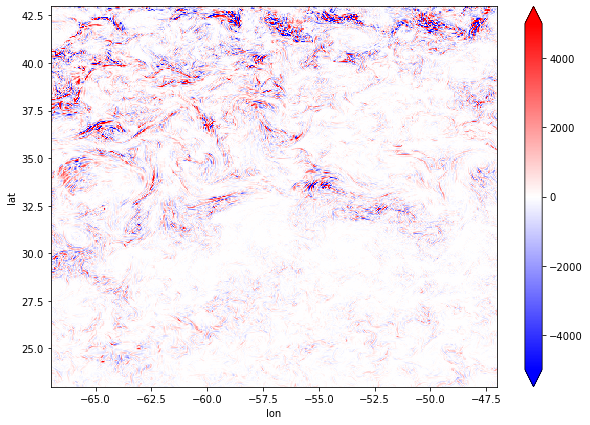

In [38]:
%matplotlib inline
WpTp_lp[20].plot(vmin=-5000, vmax=5000, cmap='bwr', figsize=(10,7))


In [41]:
# something like this for making the movieb
from xmovie import Movie
mov = Movie(WpTp_lp.chunk({'time':345}),vmin=-5000, vmax=5000, cmap='bwr' )
mov.save('/nobackup/amondal/NCData/Qmovies/Q15_1daywinavg_March2wks.mp4')

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 73% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 74% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 74% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 74% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 74% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

Movie created at Q15_1daywinavg_March2wks.mp4


In [3]:
from ipywidgets import Video, Image

b = Video.from_file('/nobackup/amondal/NCData/Qmovies/Q15_1daywinavg_March2wks.mp4', play=True)

In [4]:
b

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x04cy\xfamdat\x00\x00\…

In [5]:
W15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/', 'W', 36,36)
T15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/', 'Theta', 36,36)

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer


In [6]:
W15c = W15.W.compute()
T15c = T15.Theta.compute()

In [7]:
#W15cr = regularizeCoordinates(W15c,'linear',timeunits = 'hours')
#T15cr = regularizeCoordinates(T15c,'linear',timeunits = 'hours')
W15cr_d = xrft.detrend(xrft.detrend(W15c, dim='time', detrend_type = 'linear'), dim=['lat','lon'], detrend_type = 'linear')
T15cr_d = xrft.detrend(xrft.detrend(T15c, dim='time', detrend_type = 'linear'), dim=['lat','lon'], detrend_type = 'linear')

In [8]:
W15_short = W15cr_d[0:360]
T15_short = T15cr_d[0:360]


In [9]:
W15_lp = movingWindowAverage(W15_short, 'time', 24, 'lat')
T15_lp = movingWindowAverage(T15_short, 'time', 24, 'lat')

In [10]:
W15c_lp = W15_lp.compute()
T15c_lp = T15_lp.compute()

In [11]:
WpTp_lp = W15c_lp*T15c_lp*4.2e6

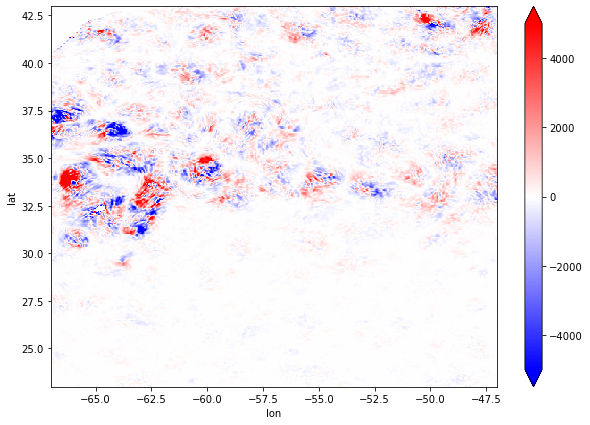

In [12]:
%matplotlib inline
WpTp_lp[20].plot(vmin=-5000, vmax=5000, cmap='bwr', figsize=(10,7))


In [14]:
# something like this for making the movieb
from xmovie import Movie
mov = Movie(WpTp_lp.chunk({'time':345}),vmin=-5000, vmax=5000, cmap='bwr' )
mov.save('/nobackup/amondal/NCData/Qmovies/Q36_1daywinavg_March2wks.mp4')

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 58% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 58% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 58% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 58% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 58% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 58% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 58% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

Movie created at Q36_1daywinavg_March2wks.mp4


In [15]:
from ipywidgets import Video, Image

c = Video.from_file('/nobackup/amondal/NCData/Qmovies/Q36_1daywinavg_March2wks.mp4', play=True)

In [16]:
c

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x03\xb9\xfb\xf6mdat\x0…

distributed.utils_perf - WARNING - full garbage collections took 62% CPU time recently (threshold: 10%)


------------------------------------------------------------------------------------------------------------------

Rerun this code once the proper libraries have downloaded!

In [17]:
W15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region_fall_winter/', 'W', 15,15)
T15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region_fall_winter/', 'Theta', 15,15)

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer


In [18]:
W15c = W15.W.compute()
T15c = T15.Theta.compute()

In [19]:
#W15cr = regularizeCoordinates(W15c,'linear',timeunits = 'hours')
#T15cr = regularizeCoordinates(T15c,'linear',timeunits = 'hours')
W15cr_d = xrft.detrend(xrft.detrend(W15c, dim='time', detrend_type = 'linear'), dim=['lat','lon'], detrend_type = 'linear')
T15cr_d = xrft.detrend(xrft.detrend(T15c, dim='time', detrend_type = 'linear'), dim=['lat','lon'], detrend_type = 'linear')

In [26]:
W15_short = W15cr_d[int(W15cr_d.time.size / 2):int(W15cr_d.time.size / 2) + 360]
T15_short = T15cr_d[int(T15cr_d.time.size / 2):int(T15cr_d.time.size / 2) + 360]


In [27]:
W15_lp = movingWindowAverage(W15_short, 'time', 24, 'lat')
T15_lp = movingWindowAverage(T15_short, 'time', 24, 'lat')

In [28]:
W15c_lp = W15_lp.compute()
T15c_lp = T15_lp.compute()

In [29]:
WpTp_lp = W15c_lp*T15c_lp*4.2e6

March 2 week movie W'T'

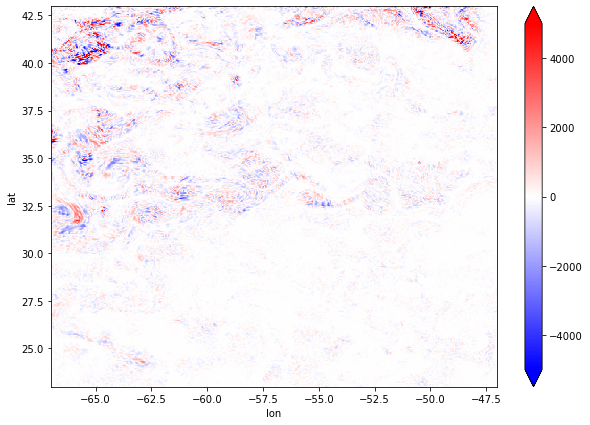

In [30]:
%matplotlib inline
WpTp_lp[20].plot(vmin=-5000, vmax=5000, cmap='bwr', figsize=(10,7))


In [31]:
# something like this for making the movieb
from xmovie import Movie
mov = Movie(WpTp_lp.chunk({'time':345}),vmin=-5000, vmax=5000, cmap='bwr' )
mov.save('/nobackup/amondal/NCData/Qmovies/Q15_1daywinavg_Dec2wks.mp4')

Movie created at Q15_1daywinavg_Dec2wks.mp4


In [33]:
from ipywidgets import Video, Image

b = Video.from_file('/nobackup/amondal/NCData/Qmovies/Q15_1daywinavg_Dec2wks.mp4', play=True)

In [34]:
b

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x03\xb6\xdc\xd8mdat\x0…